# Question 3

In [375]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from random import sample
import os


In [376]:
cur_dir = os.getcwd()
train_file_path = os.path.join(cur_dir, 'ann-train.data')
test_file_path = os.path.join(cur_dir, 'ann-test.data')
feature_file_path = os.path.join(cur_dir, 'ann-thyroid.cost')

In [377]:
# Organize features

features = pd.read_csv(feature_file_path, sep =":", header =None)
costs= list(features[features.columns[1]])
extraction= costs[18]+costs[19]
costs.append(extraction)
features = features[features.columns[:1]]
features = features.append(pd.Series("mixed"),ignore_index= True)
features_list = np.squeeze(features.to_numpy())
features = features.to_dict()[0]


In [378]:
# Prepare tranining data 
data_train = pd.read_csv(train_file_path, sep =" ", header =None)
train_data= data_train[data_train.columns[0:21]]
train_data = train_data.rename(columns=features,inplace =False) # This is pandas version

np_train_data= train_data.to_numpy() # This is numpy version
label_train = data_train[data_train.columns[21]].astype("category")
np_label_train = label_train.to_numpy()
# Prepare test data

data_test = pd.read_csv(test_file_path, sep =" ", header =None)
test_data= data_test[data_test.columns[0:21]]
test_data = test_data.rename(columns=features,inplace =False)

np_test_data = test_data.to_numpy()
label_test=data_test[data_train.columns[21]].astype("category")
np_label_test = label_test.to_numpy()


In [379]:
#Define some functions
def impurityCalculation(impurity_choice, labelsOfnode):
    
    labels, numLabels = np.unique(labelsOfnode, return_counts = True)
    total_labels= np.sum(numLabels)  
    p_numLabels = numLabels/total_labels
    
    if impurity_choice == "entropy":
        entropy = 0
        total_entropy = np.sum([entropy+ (-np.log2(ii)*ii)  for ii in p_numLabels])
        total_impurity = total_entropy
        
        
    elif impurity_choice == "gini":
        entropy = 0      
        gini= (1/2)*(1-np.sum(np.square(p_numLabels)))
        total_impurity = gini
        
    else:
        raise Exception("Sorry", impurity_choice, "is not an impurity type. ")
    
    return total_impurity


def InfoGain(attribute, label, value,impurity_choice):
    total_entropy = impurityCalculation(impurity_choice,label)
    R_split = label[attribute>value]
    L_split = label[attribute<=value]
    L_prop= len(L_split)/len(label)
    R_prop= 1- L_prop
    
    L_impurity = impurityCalculation(impurity_choice,L_split)
    R_impurity = impurityCalculation(impurity_choice,R_split)   
    
    split_impurity = L_prop*L_impurity + R_prop*R_impurity
    informationGain= total_entropy-split_impurity
    return informationGain
        
def LeftRightSplit(attribute, label, value,impurity_choice,feature_cost):
    
    
    total_entropy = impurityCalculation(impurity_choice,label)
    
    R_split = label[attribute>value]
    L_split = label[attribute<=value]
    L_prop= len(L_split)/len(label)
    R_prop= 1- L_prop
    
    L_impurity = impurityCalculation(impurity_choice,L_split)
    R_impurity = impurityCalculation(impurity_choice,R_split)   
   
    informationGain=InfoGain(attribute,label,value,impurity_choice)
    split_impurity = L_prop*L_impurity + R_prop*R_impurity
    
    
    if feature_cost!=0:
        score= -(informationGain**2)/feature_cost
        return score
    elif feature_cost ==0:
        return split_impurity


def cost_sensitive_exhaustive_search(attributes,label,impurity_choice,costVector):
    
    splitCheckAll= np.Inf
    gainAll=0
    valueSplitAll=0
    
    featureIndexSplit=0
    tempSplitCheck=0
    splitValue=0
    gainSplit=0

    
    for ft in range(0,attributes.shape[1]):
        
        feature_cost=costVector[ft]
        splitCheck= np.Inf
         
        for val in attributes[:,ft]:
            
            
            isSplit= LeftRightSplit(attributes[:,ft],label,val,impurity_choice,feature_cost)
            gainCheck =InfoGain(attributes[:,ft], label, val,impurity_choice)
            if  isSplit < splitCheck:
                splitCheck=isSplit
                tempSplitCheck=splitCheck
                splitValue= val
                gainSplit= gainCheck
                
        
        if tempSplitCheck < splitCheckAll:
            splitCheckAll=tempSplitCheck
            featureIndexSplit=ft
            valueSplitAll= splitValue
            gainAll=gainSplit
    cost = costVector[featureIndexSplit]
    if featureIndexSplit==20:
     
        costVector[20]=0
        costVector[19]=0
        costVector[0]=0
    elif featureIndexSplit==19:
        
        costVector[20]=costVector[18]
        costVector[19]=0
    elif featureIndexSplit==18:
        costVector[20]=costVector[19]
        costVector[18]=0
    else:
        costVector[featureIndexSplit]=0
    costVectorUpdate= costVector
    
    print("Updated cost:" ,costVectorUpdate)
    
    return splitCheckAll,gainAll,valueSplitAll,featureIndexSplit,costVectorUpdate,cost


def splitNode(attributes,label,impurity_choice,costVector):
    
    bestSplitScore, bestSplitInfoGain,bestValue,bestFeatureIndex,costVectorUpdate,cost = cost_sensitive_exhaustive_search(attributes,label,impurity_choice,costVector)
    
    node_impurity = impurityCalculation(impurity_choice,label)
    
    left_node = attributes[attributes[:,bestFeatureIndex]<=bestValue]
    left_node_labels = label[attributes[:,bestFeatureIndex]<=bestValue]
    
    
    right_node = attributes[attributes[:,bestFeatureIndex]>bestValue]
    right_node_labels = label[attributes[:,bestFeatureIndex]>bestValue]
    
    
    return left_node,left_node_labels, right_node,right_node_labels, node_impurity,bestSplitScore, bestSplitInfoGain,bestValue,bestFeatureIndex,costVectorUpdate,cost
    


In [380]:
# Here I made a tree implementation

In [381]:
class Node():
    def __init__(self,parent,depth):
        
        self.parent = parent
        self.depth=depth
        self.childen = []
        
        self.sampleNumber = None
        self.labelNumbers = []
        self.labelNames= []
        self.bestSplitValue= None
        self.bestSplitIndex= None
        self.splitImpurity = None
        self.isLeaf = 0
        self.leafLabelName= None
        self.cost=0
        
        
def Tree(attributes,label,node,prun,impurity_choice,costVector):
    
    node_labels, labelNumbers = np.unique(label,return_counts= True)
    node.labelNames= node_labels
    node.labelNumbers=labelNumbers
    node.sampleNumber= np.sum(labelNumbers)
    
    if len(node_labels)==1: # it is pure
        node.isLeaf=1
        node.leafLabelName=node_labels[0]
        return
    
    
    else :
        left_node_Feat,left_node_labels, right_node_Feat,right_node_labels, node_impurity,bestSplitImpurity,\
        bestSplitInfoGain,bestValue,bestFeatureIndex,costVectorUpdate,cost = splitNode(attributes,label,impurity_choice,costVector)
        #Preprunning
        if bestSplitInfoGain <= prun:
          
            labelname,labelNum= np.unique(label, return_counts=True)
            node.leafLabelName= labelname[np.argmax(labelNum)] 
            node.isLeaf = 1
            return
        # You can also add another pruning methods
        
        node.bestSplitValue=bestValue
        
        node.bestSplitIndex= bestFeatureIndex
        node.splitImpurity=bestSplitImpurity
        node.cost=cost
        
        node.L_child= Node(node,node.depth+1)
        node.R_child= Node(node,node.depth+1)
        Tree(left_node_Feat,left_node_labels,node.L_child, prun,impurity_choice,costVectorUpdate)
        Tree(right_node_Feat,right_node_labels,node.R_child,prun,impurity_choice,costVectorUpdate)
        
    


def TraverseTree(node,data):
    
    if node.isLeaf==1:
        prediction = node.leafLabelName
    
    else:
        if data[node.bestSplitIndex] <= node.bestSplitValue:
            prediction = TraverseTree(node.L_child,data)
        else:
            prediction = TraverseTree(node.R_child,data)
    return prediction


def SumCost(node,sample,init_total_cost=0):
        
    if node.isLeaf==1:
        return node.cost
    
    else:
        if sample[node.bestSplitIndex] <= node.bestSplitValue:
            init_total_cost+=node.cost
            init_total_cost+= SumCost(node.L_child,sample)
            return init_total_cost
        else:
            init_total_cost+=node.cost
            init_total_cost+=SumCost(node.R_child,sample)
            return init_total_cost


        
    

In [382]:
class DecisionTreeClassifier():
    
    def __init__(self,criterion,isPrunned="yes"):
        self.beginTree= None
        self.impurity_choice=criterion
        self.isPrunned=isPrunned
        
        
    def fit(self,data,label,prun,costVector):
        
        rootNode = Node(None,0)
        if self.isPrunned == "yes":
            Tree(data,label,rootNode,prun,self.impurity_choice,costVector)
        
        else:
            Tree(data,label,rootNode,0,self.impurity_choice,costVector)
        
        self.beginTree=rootNode
      
    def predict(self,data):
        
        if self.beginTree==None:
            print(" You need to create a tree !")
        
        else:
            prediction_list =[]
            for ii in range(0,data.shape[0]):
                prediction_list.append(TraverseTree(self.beginTree,data[ii,:]))
            
            prediction = np.asarray(prediction_list)
            return prediction
    
    def cost(self,data):
        init_cost=0
        
        for ii in range(0,data.shape[0]):
            init_cost+= SumCost(self.beginTree,data[ii,:])
        return init_cost

In [383]:
def classificationAccuracy(model, data,label, mode = "Training"):
    
    preds= model.predict(data)
    pred_accuracy = np.sum(preds==label)/data.shape[0]
    print( mode, "  accuracy is : ", 100*pred_accuracy)
    
    
    
    
    #class based accuracy
    class_labels = np.unique(label,return_counts=False)
    class_accuracy = []
   
    
    for cl in class_labels: 
        class_pred= model.predict(data[label==cl])
        class_acc= np.sum(class_pred==label[label==cl])/len(label[label==cl])
        class_avg_cost = model.cost(data[label==cl])/len(label[label==cl])
        print("Average", mode, " cost for class", cl, "is",class_avg_cost)
        print(mode, " accuracy for class ", cl, "is : ", class_acc*100 )
        class_accuracy.append(class_acc)
        
                                            
            
            
    # Confusion Matrix Creation
    
    cm= confusion_matrix(preds, label) 
    cp=ConfusionMatrixDisplay(cm,display_labels=class_labels)
    cp.plot()
    plt.show()
    

def Decision_Tree_Plot(model,attribute_list,class_names):
    
    decision_tree= model.beginTree
    
    tree=Digraph(name)
    
    
    
    
    


# Confusion Matrix for Test and Train with Average Costs

Updated cost: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 11.41, 14.51, 11.41, 25.92]
Updated cost: [1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 11.41, 14.51, 11.41, 25.92]
Updated cost: [0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 11.41, 14.51, 0, 0]
Updated cost: [0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 11.41, 14.51, 0, 0]
Updated cost: [0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 14.51, 0, 0]
Updated cost: [0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 14.51, 0, 0]
Updated cost: [0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 14.51, 0, 0]
Updated cost: [0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0]
Updated cost: [0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0]
Updated 

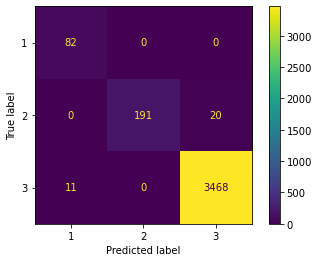

Test   accuracy is :  98.59976662777129
Average Test  cost for class 1 is 57.69273972602743
Test  accuracy for class  1 is :  84.93150684931507
Average Test  cost for class 2 is 49.69999999999994
Test  accuracy for class  2 is :  100.0
Average Test  cost for class 3 is 23.150305223410108
Test  accuracy for class  3 is :  98.83574575204531


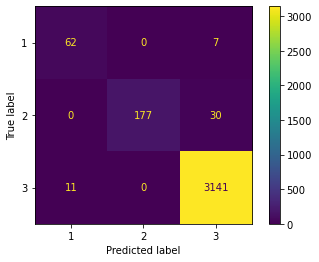

In [384]:
decision_tree= DecisionTreeClassifier("entropy","yes")
decision_tree.fit(np_train_data,np_label_train,0.025,costs)
classificationAccuracy(decision_tree,np_train_data,np_label_train,mode="Train")
classificationAccuracy(decision_tree,np_test_data,np_label_test,mode="Test")

# Done